In [26]:
import os
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utilities import cal_score, cal_mape

In [27]:
stack_idx = '19'
models = '1-34,36-37'
use_test_kfold = set([2, 7, 8, 12, 13])

is_per_area = False
add_intercept = True
is_cv_on_opt = False

### Read CV predictions and test

In [28]:
def parse_models(exp):
    exp_split = exp.split(',')
    idx_models = []
    for e in exp_split:
        if '-' in e:
            n0, n1 = e.split('-')
            idx_models.extend(list(range(int(n0), int(n1)+1, 1)))
        else:
            idx_models.append(int(e))
    return idx_models

In [29]:
idx_models = parse_models(models)
print(idx_models)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37]


In [30]:
files_in_output = [f for f in os.listdir('output/') if os.path.isfile('output/'+f)]
files_cv = {idx: [f for f in files_in_output 
                  if f.startswith('model-%02d-' % idx) and f.endswith('cv.csv')][0] 
            for idx in idx_models}
files_test_one = {idx: [f for f in files_in_output 
                        if f.startswith('model-%02d-' % idx) and f.endswith('test-one.csv')][0]
                  for idx in idx_models}
files_test_kf = {idx: [f for f in files_in_output 
                       if f.startswith('model-%02d-' % idx) and f.endswith('test-kfold.csv')][0]
                 for idx in idx_models}

In [31]:
for k in files_cv: 
    print('%2d'%k, files_cv[k])
    print('%2d'%k, files_test_kf[k])
    print('%2d'%k, files_test_one[k])

 1 model-01-lgb-cv.csv
 1 model-01-lgb-test-kfold.csv
 1 model-01-lgb-test-one.csv
 2 model-02-keras-search-cv.csv
 2 model-02-keras-search-test-kfold.csv
 2 model-02-keras-search-test-one.csv
 3 model-03-lgb-feats-selection-cv.csv
 3 model-03-lgb-feats-selection-test-kfold.csv
 3 model-03-lgb-feats-selection-test-one.csv
 4 model-04-lgb-PCA-cv.csv
 4 model-04-lgb-PCA-test-kfold.csv
 4 model-04-lgb-PCA-test-one.csv
 5 model-05-lgb-wo-per-area-cv.csv
 5 model-05-lgb-wo-per-area-test-kfold.csv
 5 model-05-lgb-wo-per-area-test-one.csv
 6 model-06-lgb-lr0.001-cv.csv
 6 model-06-lgb-lr0.001-test-kfold.csv
 6 model-06-lgb-lr0.001-test-one.csv
 7 model-07-keras-embedding-cv.csv
 7 model-07-keras-embedding-test-kfold.csv
 7 model-07-keras-embedding-test-one.csv
 8 model-08-keras-search-long-cv.csv
 8 model-08-keras-search-long-test-kfold.csv
 8 model-08-keras-search-long-test-one.csv
 9 model-09-lgb-feats-selection-75-cv.csv
 9 model-09-lgb-feats-selection-75-test-kfold.csv
 9 model-09-lgb-fea

#### Load area

In [32]:
df_train = pd.read_csv('dataset/train.csv')
df_test = pd.read_csv('dataset/test.csv')

In [33]:
cv = df_train[['building_id', 'building_area', 'total_price']]
test = df_test[['building_id', 'building_area']]

In [34]:
print('CV predictions:')
print(len(idx_models))
for i, idx_model in enumerate(idx_models):
    f = files_cv[idx_model]
    print(f)
#    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)
    
    cv = pd.merge(cv, df[['building_id', 'total_price_predict']], on='building_id')
    
    cv = cv.rename(columns = {'total_price_predict': 'pred_{}'.format(idx_model)})
    cv[f'log_pred_{idx_model}'] = np.log1p(cv[f'pred_{idx_model}'])
    cv[f'log_parea_pred_{idx_model}'] = np.log1p( cv[f'pred_{idx_model}'] / cv['building_area'] )

CV predictions:
36
model-01-lgb-cv.csv
model-02-keras-search-cv.csv
model-03-lgb-feats-selection-cv.csv
model-04-lgb-PCA-cv.csv
model-05-lgb-wo-per-area-cv.csv
model-06-lgb-lr0.001-cv.csv
model-07-keras-embedding-cv.csv
model-08-keras-search-long-cv.csv
model-09-lgb-feats-selection-75-cv.csv
model-10-lgb-feats-selection-75-lr-0.001-cv.csv
model-11-rf-cv.csv
model-12-predict-keras-search-prelu-cv.csv
model-13-predict-keras-he_uni-cv.csv
model-14-lgb-feats-selection-75-lr-0.001-rand-cv.csv
model-15-lgb-feats-selection-75-lr-0.001-rand323-cv.csv
model-16-lgb-feats-selection-68-lr-0.001-mix5-cv.csv
model-17-lgb-feats-selection-70-lr-0.001-mix5-cv.csv
model-18-lgb-feats-selection-70-lr-0.001-p5-cv.csv
model-19-lgb-search-bins-lr-0.0005-cv.csv
model-20-lgb-lr-0.0008-mix5-cv.csv
model-21-lgb-wo-per-area-long-cv.csv
model-22-lgb-wo-per-area-long-2-cv.csv
model-23-lgb-binary-cv.csv
model-24-lgb-binary-augment-cv.csv
model-25-lgb-search-bins-lr-0.0005-250-cv.csv
model-26-lgb-search-bins-lr-0.000

In [35]:
cv['log_total_price'] = np.log1p(cv['total_price'])
cv['log_parea_total_price'] = np.log1p( cv['total_price'] / cv['building_area'] )

print('Test predictions:')
for i, idx in enumerate(idx_models):
    f = files_test_kf[idx] if idx in use_test_kfold else files_test_one[idx]
    print('No. {} file: {}'.format(i, f))
    df = pd.read_csv('output/'+f)

    test = pd.merge(test, df[['building_id','total_price']], on='building_id')
        
    test = test.rename(columns = {'total_price': 'pred_{}'.format(idx)})
    test[f'log_pred_{idx}'] = np.log1p(test[f'pred_{idx}'])
    test[f'log_parea_pred_{idx}'] = np.log1p( test[f'pred_{idx}'] / test['building_area'] )

Test predictions:
No. 0 file: model-01-lgb-test-one.csv
No. 1 file: model-02-keras-search-test-kfold.csv
No. 2 file: model-03-lgb-feats-selection-test-one.csv
No. 3 file: model-04-lgb-PCA-test-one.csv
No. 4 file: model-05-lgb-wo-per-area-test-one.csv
No. 5 file: model-06-lgb-lr0.001-test-one.csv
No. 6 file: model-07-keras-embedding-test-kfold.csv
No. 7 file: model-08-keras-search-long-test-kfold.csv
No. 8 file: model-09-lgb-feats-selection-75-test-one.csv
No. 9 file: model-10-lgb-feats-selection-75-lr-0.001-test-one.csv
No. 10 file: model-11-rf-test-one.csv
No. 11 file: model-12-predict-keras-search-prelu-test-kfold.csv
No. 12 file: model-13-predict-keras-he_uni-test-kfold.csv
No. 13 file: model-14-lgb-feats-selection-75-lr-0.001-rand-test-one.csv
No. 14 file: model-15-lgb-feats-selection-75-lr-0.001-rand323-test-one.csv
No. 15 file: model-16-lgb-feats-selection-68-lr-0.001-mix5-test-one.csv
No. 16 file: model-17-lgb-feats-selection-70-lr-0.001-mix5-test-one.csv
No. 17 file: model-18-l

In [36]:
display(cv.head())
display(test.head())

,building_id,building_area,total_price,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,...,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37,log_total_price,log_parea_total_price
0,e3mMIMR3JJqCaXz1,3.418175,6.476038e+05,6.331552e+05,13.358472,12.129369,717209.94,13.483125,12.254022,6.656891e+05,...,13.360546,12.131443,6.245441e+05,13.344779,12.115676,6.319899e+05,13.356630,12.127527,13.381036,12.151933
1,LgwzgklNvy4QCtq5,4.041309,3.321452e+06,3.064324e+06,14.935338,13.538770,2899842.20,14.880167,13.483600,3.079196e+06,...,14.934792,13.538225,3.042045e+06,14.928041,13.531473,3.142342e+06,14.960479,13.563912,15.015913,13.619345
2,ucIR2NLLsC3T650L,5.584279,9.570885e+06,9.827776e+06,16.100723,14.380769,9766813.00,16.094501,14.374546,9.814852e+06,...,16.111430,14.391475,9.818275e+06,16.099756,14.379801,9.946933e+06,16.112775,14.392820,16.074236,14.354282
3,jre1pJhcQj91Kdky,13.563031,1.421501e+07,1.255350e+07,16.345510,13.738164,12699800.00,16.357097,13.749750,1.255981e+07,...,16.360720,13.753373,1.264691e+07,16.352924,13.745577,1.295773e+07,16.377203,13.769857,16.469809,13.862462
4,rQpYpY9nRG7X5mmr,4.688108,7.627120e+05,1.215194e+06,14.010415,12.465389,2012610.50,14.514944,12.969916,1.128419e+06,...,13.833961,12.288935,9.305770e+05,13.743561,12.198536,9.859947e+05,13.801407,12.256382,13.544637,11.999613


,building_id,building_area,pred_1,log_pred_1,log_parea_pred_1,pred_2,log_pred_2,log_parea_pred_2,pred_3,log_pred_3,...,log_parea_pred_33,pred_34,log_pred_34,log_parea_pred_34,pred_36,log_pred_36,log_parea_pred_36,pred_37,log_pred_37,log_parea_pred_37
0,X5gsdTWGS3W7JJQB,3.418175,1.526912e+07,16.541343,15.312236,12470072.0,16.338842,15.109735,1.531685e+07,16.544464,...,15.177853,1.265085e+07,16.353235,15.124128,1.298618e+07,16.379396,15.150290,1.304845e+07,16.384180,15.155073
1,BTshNOJyKHnT2YIT,7.726227,3.924241e+06,15.182684,13.138065,3916552.2,15.180723,13.136104,3.977095e+06,15.196062,...,13.129452,3.890897e+06,15.174151,13.129532,3.897411e+06,15.175823,13.131204,3.897545e+06,15.175858,13.131239
2,dhdymr0lV8N5kZOT,12.170581,1.096127e+07,16.209879,13.710858,11912735.0,16.293119,13.794098,1.084967e+07,16.199646,...,13.676769,1.078313e+07,16.193493,13.694473,1.049745e+07,16.166643,13.667623,1.035078e+07,16.152573,13.653552
3,VEwyGGMcD56w5BOc,2.252256,6.155550e+06,15.632865,14.820933,5940670.0,15.597333,14.785400,6.015238e+06,15.609807,...,14.815015,6.080412e+06,15.620583,14.808651,6.139949e+06,15.630327,14.818395,6.120593e+06,15.627170,14.815237
4,wmUeMoJZfsqaSX9b,5.813985,1.062995e+06,13.876602,12.116340,1088488.1,13.900301,12.140039,1.027248e+06,13.842395,...,12.159895,1.092040e+06,13.903559,12.143297,1.106728e+06,13.916919,12.156657,1.098338e+06,13.909310,12.149048


### Check models scores

In [37]:
for i, idx_model in enumerate(idx_models):
    print('%2d'%i, 'model-%02d'%idx_model, '%.6f'%cal_score(cv['total_price'], cv[f'pred_{idx_model}']))

 0 model-01 5870.873059
 1 model-02 5400.852164
 2 model-03 5877.873452
 3 model-04 5713.867808
 4 model-05 5724.869598
 5 model-06 5886.873769
 6 model-07 5171.836449
 7 model-08 5514.858826
 8 model-09 5872.873118
 9 model-10 5897.873845
10 model-11 5075.838018
11 model-12 5486.856963
12 model-13 5506.858055
13 model-14 5908.873901
14 model-15 5900.873836
15 model-16 5907.874126
16 model-17 5905.874165
17 model-18 5908.874297
18 model-19 5911.874156
19 model-20 5908.874040
20 model-21 5758.870702
21 model-22 5752.870671
22 model-23 5852.871357
23 model-24 5866.873835
24 model-25 5908.874238
25 model-26 5918.873998
26 model-27 5892.873194
27 model-28 5901.874202
28 model-29 5884.873848
29 model-30 5864.872101
30 model-31 5783.868923
31 model-32 5930.875106
32 model-33 5976.875715
33 model-34 5942.875172
34 model-36 5989.876236
35 model-37 5980.875836


In [38]:
cv['constant_1'] = 1
test['constant_1'] = 1

if is_per_area:
    cols_opt = [f'log_parea_pred_{idx}' for idx in idx_models]
else:
    cols_opt = [f'log_pred_{idx}' for idx in idx_models]

if add_intercept:
    cols_opt.append('constant_1')

### Define opt function

In [39]:
def objective(x, cv, metric, best_score, best_coeffs, verbose):
    cv_pred_final = cv[cols_opt].dot(x)
    
    if is_per_area:
        cv_pred_final = np.expm1(cv_pred_final) * cv['building_area']
    else:
        cv_pred_final = np.expm1(cv_pred_final)

    score = cal_score(cv['total_price'], cv_pred_final)
    if score > best_score[metric]:
        best_score[metric] = score
        best_coeffs[metric] = x.copy()
        if verbose:
            print('find better score:')
            print('score: ', score)
            print('coeffs: ', x)
            print()
    
    if metric == 'mape':
        return cal_mape(cv['total_price'], cv_pred_final)
    elif metric == 'mse':
        return mean_squared_error(cv['total_price'], cv_pred_final)
    elif metric == 'mae':
        return mean_absolute_error(cv['total_price'], cv_pred_final)
    elif metric == 'smooth':
        return cal_score_smooth(cv['total_price'], cv_pred_final)
    else:
        raise Exception('metric unknown: {}'.format(metric))
#    return 1 - (cal_score(cv['total_price'], cv_pred_final)/10000)

### Initialization

In [40]:
len_x = len(cols_opt)
rev_len_x = 1/len_x
x0s = [[1/len_x for i in range(len_x)],
       [0 for i in range(len_x)],
       [0.1 for i in range(len_x)],
       [0.2 for i in range(len_x)],
       [0.5 for i in range(len_x)],
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
       (np.random.randn(len_x)+1)/len_x,
      ]
#bounds = tuple([(0, 1) for i in range(len_x-1)] + [(-2, 2)])

### CV
not run yet

In [41]:
from sklearn.model_selection import KFold

if is_cv_on_opt:
    cv = cv.reset_index(drop=True)
    #cv = cv.head(100)

    score_list = []

    kf = KFold(shuffle= True)
    for idx_train, idx_val in kf.split(cv):

        best_score = {}
        best_coeffs = {}

        cv_fold_train = cv.loc[idx_train].reset_index(drop=True)
        cv_fold_val = cv.loc[idx_train].reset_index(drop=True)

        for metric in ['mape']:
        #for metric in ['mape', 'mae', 'mse']:
            best_score[metric] = 0
            best_coeffs[metric] = []
            for x0 in x0s:
                print('Optimizing with init x0: {}'.format(x0))
                print()
                minimize(objective, x0, args=(cv_fold_train, metric, best_score, best_coeffs, 
                                              True), 
                         tol=1e-4) #, bounds=bounds

        val_pred_final = cv_fold_val[cols_opt].dot(best_coeffs['mape'])
        if is_per_area:
            val_pred_final = np.expm1(val_pred_final) * cv_fold_val['building_area']
        else:
            val_pred_final = np.expm1(val_pred_final)
        score = cal_score(cv_fold_val['total_price'], val_pred_final)

        score_list.append(score)

    print('CV score ?: {}; {}'.format(np.mean(score_list), score_list))

### Optimize

In [42]:
best_score = {}
best_coeffs = {}

for metric in ['mape']:
#for metric in ['mape', 'mae', 'mse']:
    best_score[metric] = 0
    best_coeffs[metric] = []
    for x0 in x0s:
        print('Optimizing with init x0: {}'.format(x0))
        print()
        minimize(objective, x0, args=(cv, metric, best_score, best_coeffs, True), tol=1e-4)

Optimizing with init x0: [0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703, 0.02702702702702703]

find better score:
score:  340.67387541056735
coeffs:  [0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703 0.02702703
 0.0270

find better score:
score:  5950.876282110517
coeffs:  [0.02668114 0.02860768 0.02711308 0.02662825 0.02872571 0.0268901
 0.02842958 0.02927677 0.02677258 0.02691746 0.01572108 0.02843707
 0.02823904 0.02699177 0.0269104  0.02708366 0.0271192  0.0272846
 0.02707963 0.02702514 0.02860409 0.02863733 0.0280279  0.02874453
 0.02730543 0.02687984 0.02727893 0.02720682 0.02730874 0.02831881
 0.02817933 0.02929414 0.0311046  0.02933944 0.03162825 0.03217575
 0.02109371]

find better score:
score:  5950.876282110519
coeffs:  [0.02668114 0.02860766 0.02711308 0.02662825 0.02872572 0.0268901
 0.02842958 0.02927677 0.02677258 0.02691746 0.01572108 0.02843707
 0.02823904 0.02699177 0.0269104  0.02708366 0.0271192  0.0272846
 0.02707963 0.02702514 0.02860409 0.02863733 0.0280279  0.02874453
 0.02730543 0.02687984 0.02727893 0.02720682 0.02730874 0.02831881
 0.02817933 0.02929414 0.0311046  0.02933944 0.03162825 0.03217575
 0.02109371]

find better score:
score:  5950.8762821105265
coeffs:  [0.026681

find better score:
score:  6014.878972110459
coeffs:  [-3.90674459e-02  1.15832455e-02  9.26012621e-02  1.55502884e-02
  5.54729832e-02  1.91920049e-02  2.10117823e-02  7.77696643e-02
 -1.93130829e-02 -1.97981765e-02 -1.21730425e-01  2.96436813e-02
  9.88145370e-04  4.34967621e-03 -1.70994602e-02 -9.14052092e-03
 -7.98449051e-03 -4.62394961e-03 -1.17361662e-01 -1.16377702e-01
  3.95579251e-02  4.97081670e-02  8.92937602e-02  1.56564735e-01
 -8.39256864e-02 -1.50048593e-01  1.06253101e-01 -5.05557799e-02
  2.43544555e-02  8.46133668e-02  9.00353619e-02 -2.29742128e-02
  1.33829609e-01 -2.50127328e-04  2.58090256e-01  4.23743508e-01
 -7.27685741e-02]

find better score:
score:  6014.879053603396
coeffs:  [-0.06871153  0.01915265  0.13765119 -0.00855681  0.05555041  0.02772462
  0.02621046  0.07050973 -0.03622683 -0.00133238 -0.13108354  0.01398704
  0.01802424  0.0397114   0.00156389  0.01568766  0.01644495  0.01261818
 -0.16220192 -0.15396663  0.03253605  0.05016389  0.04813914  0.19430

find better score:
score:  6018.879119498371
coeffs:  [-0.15827206  0.01843728  0.16918686  0.0150289   0.06922087  0.00877316
  0.02070151  0.07479956 -0.10952165  0.00799699 -0.13180757  0.01595542
  0.01300893  0.09230041  0.00439602  0.05226592  0.05850549  0.03641104
 -0.22333203 -0.20495022  0.02422379  0.06531889  0.02361614  0.19540611
 -0.12118439 -0.33102176  0.22563887  0.00697644  0.09745401  0.09433566
  0.0635053  -0.01067145 -0.08383731  0.05619099  0.29169824  0.57621758
 -0.05776586]

find better score:
score:  6018.87911949874
coeffs:  [-0.15827204  0.01843728  0.16918686  0.0150289   0.06922087  0.00877316
  0.02070151  0.07479956 -0.10952165  0.00799699 -0.13180757  0.01595542
  0.01300893  0.09230041  0.00439602  0.05226592  0.05850549  0.03641104
 -0.22333203 -0.20495022  0.02422379  0.06531889  0.02361614  0.19540611
 -0.12118439 -0.33102176  0.22563887  0.00697644  0.09745401  0.09433566
  0.0635053  -0.01067145 -0.08383731  0.05619099  0.29169824  0.57621758
 -

find better score:
score:  6018.8791659379685
coeffs:  [-0.17236789  0.0135204   0.16833189  0.00843149  0.07558446  0.02247766
  0.02431265  0.07638445 -0.08365093 -0.06588483 -0.1283573   0.01555342
  0.01458035  0.18483358 -0.11617959  0.06609202  0.12821968 -0.02483848
 -0.26652556 -0.23421629 -0.0212928   0.10676036 -0.03187097  0.15066919
 -0.03562553 -0.50069416  0.22705056  0.25910419  0.0610599   0.14156044
  0.07450122 -0.05728014 -0.2831021   0.13486945  0.47858777  0.59224194
 -0.05552443]

find better score:
score:  6018.879165938033
coeffs:  [-0.17236787  0.0135204   0.16833189  0.00843149  0.07558446  0.02247766
  0.02431265  0.07638445 -0.08365093 -0.06588483 -0.1283573   0.01555342
  0.01458035  0.18483358 -0.11617959  0.06609202  0.12821968 -0.02483848
 -0.26652556 -0.23421629 -0.0212928   0.10676036 -0.03187097  0.15066919
 -0.03562553 -0.50069416  0.22705056  0.25910419  0.0610599   0.14156044
  0.07450122 -0.05728014 -0.2831021   0.13486945  0.47858777  0.59224194


find better score:
score:  6018.879167820717
coeffs:  [-0.1684429   0.01612145  0.1640957   0.0026363   0.07903905  0.01965314
  0.0240938   0.07023322 -0.07897494 -0.0728412  -0.12664894  0.01976109
  0.01314793  0.20502022 -0.1342047   0.06875434  0.14247895 -0.03865092
 -0.26574765 -0.24412564 -0.02811446  0.10851871 -0.01880833  0.15669474
 -0.02630751 -0.51101917  0.23107746  0.28070828  0.04126125  0.13095873
  0.07501855 -0.0677317  -0.2806151   0.14803058  0.47304767  0.59467247
 -0.05472873]

find better score:
score:  6018.87916804891
coeffs:  [-0.16801001  0.01564947  0.16387242  0.00195216  0.07943821  0.01973481
  0.02476647  0.06970451 -0.07878256 -0.07415365 -0.12641146  0.01977185
  0.01332362  0.20620037 -0.13656151  0.06871055  0.14341039 -0.03972347
 -0.26554797 -0.24465784 -0.02885513  0.10887789 -0.01828755  0.16002587
 -0.02483853 -0.51200836  0.23011606  0.28356033  0.03985384  0.131591
  0.0736839  -0.06963785 -0.28085398  0.14819334  0.47412708  0.59456653
 -0.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:155: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/optimize/linesearch.py:391: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


Optimizing with init x0: [ 0.05840281  0.08428003  0.02357447  0.01365567  0.03361005  0.03320353
  0.01773818  0.01807664  0.01459417  0.00711973  0.01200565  0.02741301
  0.05721401  0.00778706  0.00301909  0.12150663 -0.00295693  0.03942252
  0.07507196  0.05511988  0.04673891  0.02217088  0.0560146   0.06709724
  0.03566316 -0.00680731  0.03300838  0.0356874   0.01432522  0.05825308
  0.0585763   0.00281447  0.04185215  0.06461555  0.01864164 -0.00618301
  0.04011788]

Optimizing with init x0: [ 0.05318761  0.02460851  0.037807   -0.02384521  0.013462    0.03399896
  0.09972168  0.06053027  0.00776531  0.02293739  0.04865512  0.00626001
  0.05412571  0.0019105  -0.00934919 -0.00563557  0.08659433  0.03345008
  0.05694164 -0.01181743 -0.01270818  0.08663032  0.05916189  0.0589663
  0.00466912  0.0598388   0.03238766  0.02793622 -0.04191682 -0.03759943
  0.0297142   0.03896917  0.02437655  0.00414082  0.02885035  0.00764113
  0.08906679]

Optimizing with init x0: [ 0.02997229  0.0349

In [43]:
display(best_score)
display(best_coeffs)

{'mape': 6018.879168310711}

{'mape': array([-1.66950032e-01,  1.43596958e-02,  1.63762676e-01,  3.03382603e-04,
         8.11453773e-02,  1.90608287e-02,  2.50232414e-02,  7.16506472e-02,
        -7.81621434e-02, -7.53399591e-02, -1.26386089e-01,  2.04672846e-02,
         1.22929751e-02,  2.11783547e-01, -1.40797399e-01,  6.98488433e-02,
         1.47554681e-01, -4.27273462e-02, -2.65726533e-01, -2.48244460e-01,
        -2.99468151e-02,  1.09679325e-01, -1.39643323e-02,  1.62090579e-01,
        -2.34201622e-02, -5.14563885e-01,  2.30711402e-01,  2.87567143e-01,
         3.41535901e-02,  1.28862265e-01,  7.14545932e-02, -7.16684924e-02,
        -2.79509996e-01,  1.52334124e-01,  4.70406564e-01,  5.95772894e-01,
        -5.60384922e-02])}

### Compute submission

In [44]:
test_pred_final = pd.DataFrame({'building_id': test['building_id']})

test_pred_final['total_price'] = test.loc[:,cols_opt].dot(best_coeffs['mape'])

if is_per_area:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price']) * test['building_area'] 
else:
    test_pred_final['total_price'] = np.expm1(test_pred_final['total_price'])
    
test_pred_final['total_price'] = np.clip(test_pred_final['total_price'], 0, None)

In [45]:
unique_prices = np.sort(df_train['total_price'].unique())

def find_nearest(array, value):
    return array[(np.fabs(array - value)).argmin()]

def correct_prices(sq):
    return [find_nearest(unique_prices, x) for x in sq]

test_pred_final['total_price'] = correct_prices(test_pred_final['total_price'])

In [46]:
if is_per_area:
    test_pred_final.to_csv('output/stack_spopt-parea_{}_{}.csv'.format(stack_idx, models), index=False)
else:
    test_pred_final.to_csv('output/stack_spopt_{}_{}.csv'.format(stack_idx, models), index=False)

### Plots

In [47]:
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


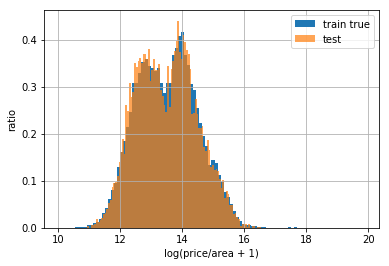

In [48]:
plt.hist(cv['log_parea_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price'] / test['building_area']), bins=100, label='test',
         normed=True, alpha=0.7)
plt.xlabel('log(price/area + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


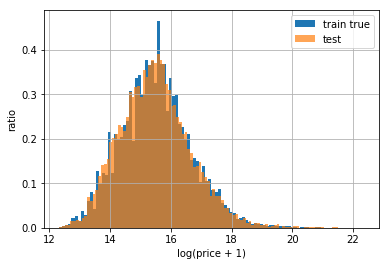

In [49]:
plt.hist(cv['log_total_price'], bins=100, label='train true', normed=True)
plt.hist(np.log1p(test_pred_final['total_price']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(price + 1)'); plt.ylabel('ratio')
plt.legend(); plt.grid(); plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


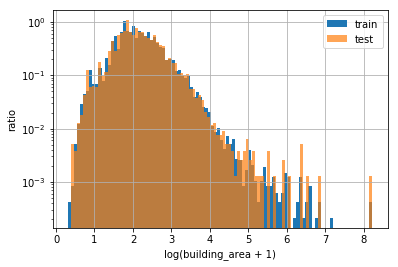

In [50]:
plt.hist(np.log1p(cv['building_area']), bins=100, label='train', normed=True)
plt.hist(np.log1p(test['building_area']), bins=100, label='test', normed=True, alpha=0.7)
plt.xlabel('log(building_area + 1)'); plt.ylabel('ratio'); plt.yscale('log')
plt.legend(); plt.grid(); plt.show()